# Predict CO2 Emissions in Rwanda

O objetivo deste desafio é criar modelos de aprendizado de máquina que usam dados de emissões de código aberto (de observações do satélite Sentinel-5P) para prever as emissões de carbono.

## Importando Bibliotecas

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Lendo Arquivos e identificando features

In [2]:
DATA_PATH = '/kaggle/input/playground-series-s3e20'

#Load files

train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
test['emission'] = float('nan')
test_submission = test

samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

train.drop('ID_LAT_LON_YEAR_WEEK', axis = 1, inplace = True)
test = test.drop('ID_LAT_LON_YEAR_WEEK', axis = 1)


train.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


# Análise Gráfica

In [3]:
# Criação da coluna de data usando as colunas de "ano" e "número da semana"
temp_train = train
temp_train['data'] = pd.to_datetime(train['year'].astype(str) + train['week_no'].astype(str) + '-1', format='%Y%U-%w')

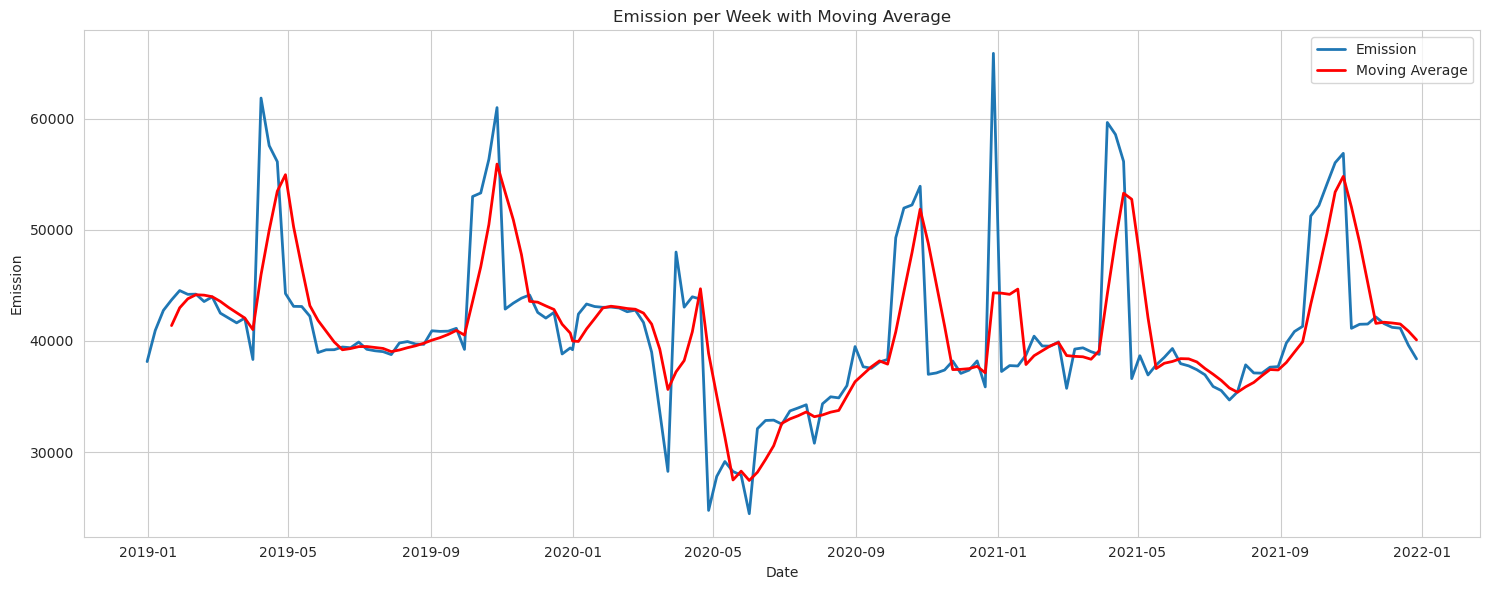

In [4]:
def plot_emission_with_ma(df, window_size=4):  # window_size é o tamanho da janela da média móvel
    plt.figure(figsize=(15, 6))
    df_grouped = df.groupby('data')['emission'].sum().reset_index()  # Altere 'date' para 'Data' se necessário

    sns.set_style("whitegrid")
    sns.lineplot(data=df_grouped, x='data', y='emission', linewidth=2, label='Emission')
    
    # Calcula a média móvel com o tamanho da janela especificado
    df_grouped['Moving_Avg'] = df_grouped['emission'].rolling(window=window_size).mean()
    sns.lineplot(data=df_grouped, x='data', y='Moving_Avg', linewidth=2, label='Moving Average', color='red')
    
    plt.xlabel('Date')
    plt.ylabel('Emission')
    plt.title('Emission per Week with Moving Average')
    plt.tight_layout()
    plt.legend()
    
    plt.show()

# Chamando a função com o DataFrame 'train' e tamanho da janela de média móvel igual a 4
plot_emission_with_ma(temp_train, window_size=4)
del temp_train

In [5]:
from haversine import haversine
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

def get_id(row):
    return int(''.join(filter(str.isdigit, str(row['latitude']))) + ''.join(filter(str.isdigit, str(row['longitude']))))

train['id'] = train[['latitude', 'longitude']].apply(lambda row: get_id(row), axis=1)
test['id'] = test[['latitude', 'longitude']].apply(lambda row: get_id(row), axis=1)
new_ids = {id_: new_id for new_id, id_ in enumerate(train['id'].unique())}
train['id'] = train['id'].map(new_ids)
test['id'] = test['id'].map(new_ids)

def get_month(row):
    date = dt.datetime.strptime(f'{row["year"]}-{row["week_no"]+1}-1', "%Y-%W-%w")
    return date.month

rwanda_center = (-1.9607, 29.9707)
park_biega = (-1.8866, 28.4518)
kirumba = (-0.5658, 29.1714)
massif = (-3.42, 28.592)
lake = (-2.0073, 31.6269)

def cluster_features(df, cluster_centers):
    for i, cc in enumerate(cluster_centers.values()):
        df[f'cluster_{i}'] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), cc, unit='ft'), axis=1)
    return df
    
y = train['emission']

def preprocessing(df):
    
    cols_save = ['id', 'latitude', 'longitude', 'year', 'week_no', 'Ozone_solar_azimuth_angle']
    df = df[cols_save]
    
    good_col = 'Ozone_solar_azimuth_angle'
    df[good_col] = df.groupby(['id', 'year'])[good_col].ffill().bfill()
    

            
    df['rot_15_x'] = (np.cos(np.radians(15)) * df['longitude']) + \
                     (np.sin(np.radians(15)) * df['latitude'])
    
    df['rot_15_y'] = (np.cos(np.radians(15)) * df['latitude']) + \
                     (np.sin(np.radians(15)) * df['longitude'])

    df['rot_30_x'] = (np.cos(np.radians(30)) * df['longitude']) + \
                     (np.sin(np.radians(30)) * df['latitude'])

    df['rot_30_y'] = (np.cos(np.radians(30)) * df['latitude']) + \
                     (np.sin(np.radians(30)) * df['longitude'])
    
    for col, coors in zip(
        ['dist_rwanda', 'dist_park', 'dist_kirumba', 'dist_massif', 'dist_lake'], 
        [rwanda_center, park_biega, kirumba, massif, lake]
    ):
        df[col] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), coors, unit='ft'), axis=1)
    
    df['month'] = df[['year', 'week_no']].apply(lambda row: get_month(row), axis=1)
    df['is_covid'] = (df['year'] == 2020) & (df['month'] > 2) | (df['year'] == 2021) & (df['month'] == 1)
    df['is_lockdown'] = (df['year'] == 2020) & ((df['month'].isin([3,4])))
    
    lags = 4  # Defina o número de lags que você deseja criar
    for lag in range(1, lags + 1):
        df[f'Y_{good_col}_{lag}'] = df.groupby(['id', 'year'])[good_col].shift(lag).fillna(0)
        df[f'Y_{good_col}_{-lag}'] = df.groupby(['id', 'year'])[good_col].shift(-lag).fillna(0)
    
    df.fillna(0, inplace=True)
    
    return df
    
train = preprocessing(train)
test = preprocessing(test)

df = pd.concat([train, test], axis=0, ignore_index=True)
coordinates = df[['latitude', 'longitude']].values
clustering = KMeans(n_clusters=12, max_iter=1000, random_state=42).fit(coordinates)
cluster_centers = {i: tuple(centroid) for i, centroid in enumerate(clustering.cluster_centers_)}
df = cluster_features(df, cluster_centers)

train = df.iloc[:-len(test),:]
test = df.iloc[-len(test):,:]
del df

X = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [6]:
# Treinar o modelo com os melhores parâmetros usando o conjunto de treinamento completo
rf = RandomForestRegressor(n_estimators = 82, max_depth =20, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Fazer previsões no conjunto de teste usando o modelo treinado

samplesubmission['emission'] = rf.predict(test) * 1.07
samplesubmission.to_csv('submission.csv', index=False)


In [7]:
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
train = pd.concat([X, y], axis=1)

submission_fix = samplesubmission.copy()
submission_fix.loc[test['longitude']==29.321, 'emission'] = train.loc[(train['year']==2021) & (train['week_no']<=48) &(train['longitude']==29.321),'emission'].values

submission_fix.to_csv('submission.csv', index=False)

In [8]:
# Dividir a coluna em várias colunas separadas
submission_fix[['id', 'latitude', 'longitude', 'year', 'week_no']] = submission_fix['ID_LAT_LON_YEAR_WEEK'].str.split('_', expand=True)
# Remover a coluna original
submission_fix.drop(columns=['ID_LAT_LON_YEAR_WEEK','id'], inplace=True)
temp_train = train [['latitude', 'longitude', 'year', 'week_no','emission']] 

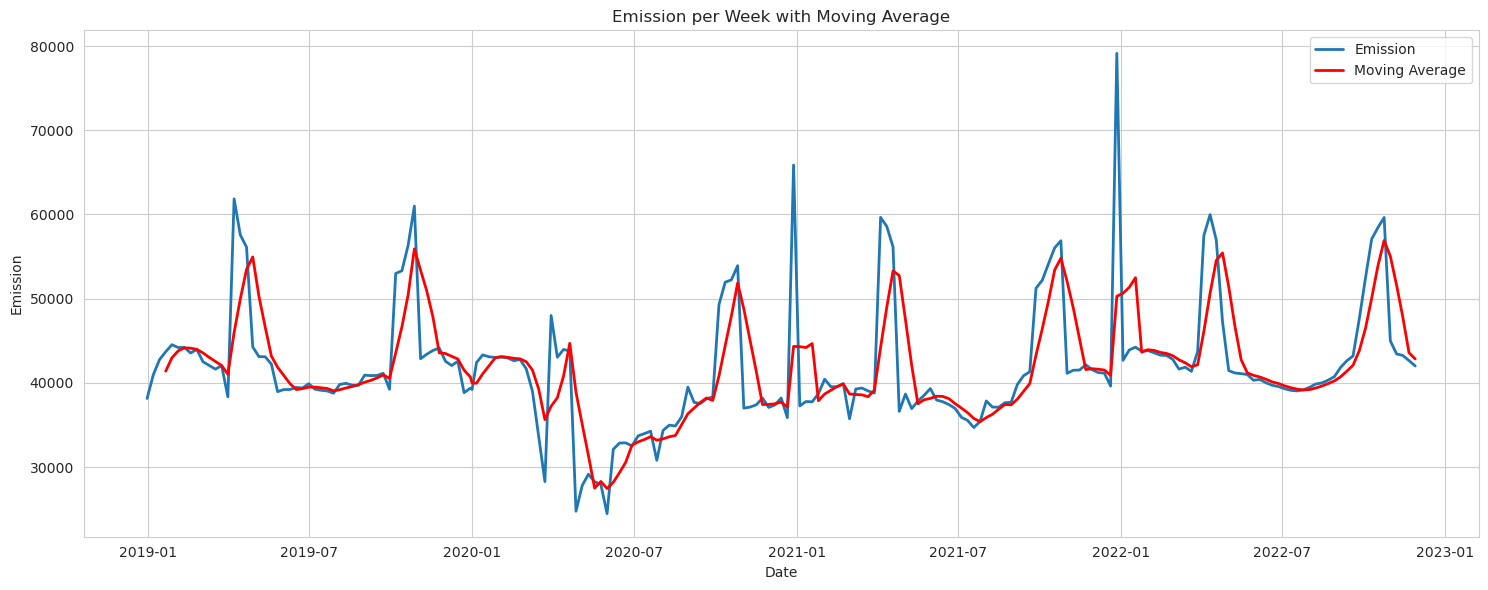

In [9]:
# Unir os DataFrames
merged_df = pd.concat([temp_train, submission_fix], axis=0)
merged_df['data'] = pd.to_datetime(merged_df['year'].astype(str) + merged_df['week_no'].astype(str) + '-1', format='%Y%U-%w')
# Chamando a função com o DataFrame 'train' e tamanho da janela de média móvel igual a 4
plot_emission_with_ma(merged_df, window_size=4)
